[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/blob/main/tarea1-redes-densas/2_backpropagation.ipynb)

# 2. Retropropagación
Curso: Aprendizaje profundo

Alumno: Daniel Alonso

Programa el algoritmo de retropropagación usando numpy para una tarea de clasificación binaria presuponiendo una red densa cons dos capas ocultas. Esta red tiene una función de activación logística en todas sus neuronas y se entrena minimizando la función de pérdida de entropía cruzada binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.

-----------------------

In [1]:
import numpy as np

# visualizacion de resultados
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# establecer una semilla
np.random.seed(0)

En la siguiente imagen se muestra la arquitectura de una red densa compuesta de una capa de entradas $\boldsymbol{a}^{\left \{ 1 \right \}} = \boldsymbol{x}^{(i)}$, un par de capas ocultas y una capa de salida con una sola neurona con función de activación sigmoide.

Nótese que el diagrama tiene como objetivo ser un esquema, en el algoritmo se permiten $n$ entradas, y $m$ neuronas en las capas ocultas, además se separaron las neuronas en la entrada $\boldsymbol{z}^{\left \{ i \right \}}$ y su salida $\boldsymbol{a}^{\left \{ i \right \}}$ después de aplicar la función de activación logística, esto para ilustrar de mejor manera el algoritmo de repropagación.

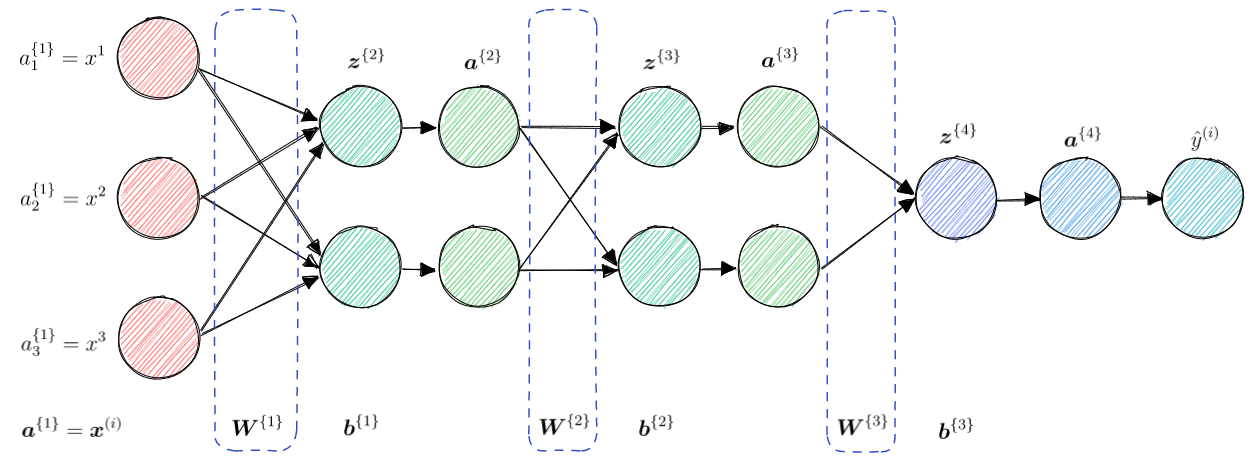

La función de activación sigmoide se define como: 

\begin{equation}
\sigma(z)=\dfrac{1}{1+e^{-z}}
\end{equation}

La derivada de la función sigmoide está expresada en función de la misma:

\begin{equation}
\frac{\partial \sigma(z)}{\partial z}=\sigma(z)(1-\sigma(z))
\end{equation}


In [3]:
def sigmoide(z):
  return 1 / (1 + np.exp(-z))

In [4]:
def derivada_sigmoide(x):
  return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

El objetivo de la red densa es realizar una tarea de clasificación binaria, por lo que se utiliza la función de pérdida de entropía cruzada binaria $ECB$:

\begin{equation}
ECB(\boldsymbol{y,\hat{y}}) = -\sum_{i=1}^{N}\left [ y^{(i)}\log \hat{y}^{(i)} + (1-y^{(i)})\log(1-\hat{y}^{(i)}) \right ]
\end{equation}

In [5]:
def entropia_cruzada_binaria(y, p):
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

La exactitud para medir el rendimiento del modelo aprendido por la red neuronal densa está dado por:

\begin{equation}
exactitud=\dfrac{correctos}{total}
\end{equation}

In [6]:
def exactitud(y, y_predicha):
  return (y == y_predicha).mean() * 100

## Forward

A continuación, se describe la función que propaga hacia adelante una entrada $\boldsymbol{x}^i$.


*   Para las capas ocultas se tienen 2 matrices de pesos con sus correspondientes vectores de sesgos: $\left \{ \boldsymbol{W}^{\left \{ 1 \right \}}, \boldsymbol{b}^{\left \{ 1 \right \}} \right \} , \left \{ \boldsymbol{W}^{\left \{ 2 \right \}}, \boldsymbol{b}^{\left \{ 2 \right \}} \right \}$
*   Para la capa de salida se tiene 1 matriz de pesos con su correspondiente vector de sesgos: $\left \{ \boldsymbol{W}^{\left \{ 3 \right \}}, \boldsymbol{b}^{\left \{ 3 \right \}} \right \}$

Por lo tanto, la propagación hacia adelante se realiza de la siguiente manera:

\begin{align}
\boldsymbol{a}^{\left \{ 1 \right \}} &= \boldsymbol{x}^{(i)} \\
\boldsymbol{z}^{\left \{ 2 \right \}} &= \boldsymbol{W}^{\left \{ 1 \right \}} \cdot \boldsymbol{a}^{\left \{ 1 \right \}} + \boldsymbol{b}^{\left \{ 1 \right \}} \\
\boldsymbol{a}^{\left \{ 2 \right \}} &= \sigma(\boldsymbol{z}^{\left \{ 2 \right \}}) \\
\boldsymbol{z}^{\left \{ 3 \right \}} &= \boldsymbol{W}^{\left \{ 2 \right \}} \cdot \boldsymbol{a}^{\left \{ 2 \right \}} + \boldsymbol{b}^{\left \{ 2 \right \}} \\
\boldsymbol{a}^{\left \{ 3 \right \}} &= \sigma(\boldsymbol{z}^{\left \{ 3 \right \}}) \\
\boldsymbol{z}^{\left \{ 4 \right \}} &= \boldsymbol{W}^{\left \{ 3 \right \}} \cdot \boldsymbol{a}^{\left \{ 3 \right \}} + \boldsymbol{b}^{\left \{ 3 \right \}} \\
\boldsymbol{a}^{\left \{ 4 \right \}} &= \sigma(\boldsymbol{z}^{\left \{ 4 \right \}}) \\
\hat{y}^{(i)} &= \boldsymbol{a}^{\left \{ 4 \right \}}
\end{align}

In [7]:
def forward(x,W1,b1,W2,b2,W3,b3):
  a1 = x[:, np.newaxis]
  z2 = np.dot(W1.T,a1)+b1
  a2 = sigmoide(z2)
  z3 = np.dot(W2.T,a2)+b2
  a3 = sigmoide(z3)
  z4 = np.dot(W3.T,a3)+b3
  y_hat = sigmoide(z4)
  return z2,a2,z3,a3,z4,y_hat

## Backprop

En el entrenamiento se busca encontrar el valor de los pesos $\boldsymbol{W}$ y sesgos $\boldsymbol{b}$ que minimicen una función de pérdida $\mathcal{L}$.

Existen varios algoritmos de optimización para este problema pero el que más se utiliza es el de descenso por gradiente, el cual es un algoritmo iterativo que va moviendo los pesos y sesgos hacia donde la pérdida descienda más rápido:

\begin{equation}
\boldsymbol{\theta}^{\left [ t+1 \right ]} = \boldsymbol{\theta}^{\left [ t \right ]}-\alpha \nabla \mathcal{L}(\boldsymbol{\theta}^{\left [ t \right ]})
\end{equation}

donde $\boldsymbol{\theta}=\left \{ \boldsymbol{W}, \boldsymbol{b} \right \}$, y $\alpha$ es la tasa de aprendizaje.

Para esta en red en particular, dado que se tienen 3 matrices de pesos y 3 vectores de sesgos es necesario calcular las derivadas parciales de la pérdida respecto a cada peso y sesgo, tal que:

\begin{equation}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \left [\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}}  \right ]
\end{equation}

y actualizarlos en cada paso con la ecuación anterior.

El algoritmo de repropagación calcula las derivadas parciales de la pérdida respecto a cada peso y sesgo capa por capa, empezando con la salida y propagando hacia atrás, de tal manera que no se repitan los cálculos. 

De forma intuitiva, el gradiente le dice al parámetro $\theta$ que tanto necesita cambiar de manera negativa o positiva para minimizar $\mathcal{L}$, y para calcular los gradientes se utiliza la regla de la cadena. A continuación se muestran los cálculos realizados para cada uno de los pesos y sesgos.



### Cálculo de $\left [\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}}  \right ]$

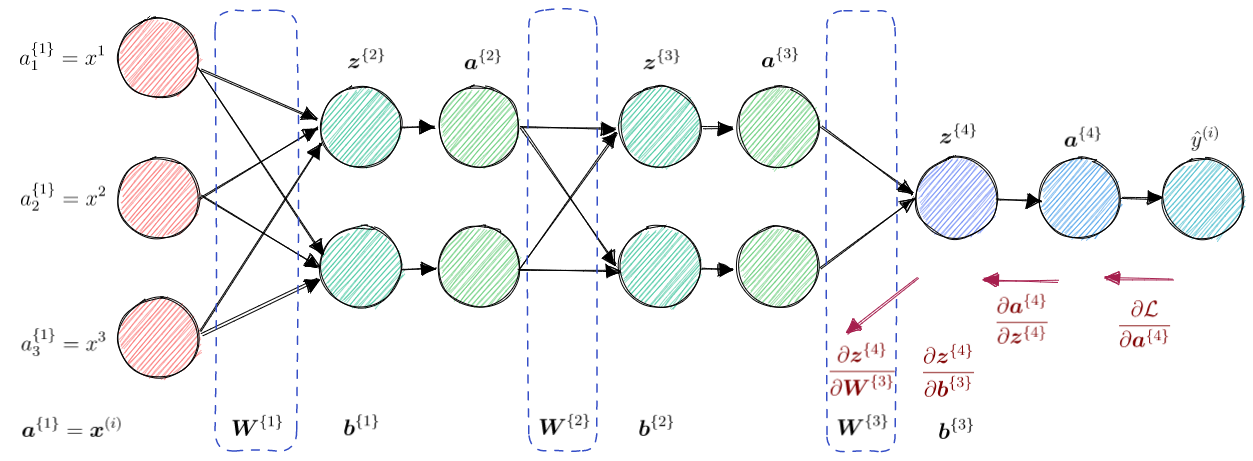

Como en el paso hacia adelante se hace una composición de funciones, para realizar el cálculo de los gradientes de la función de pérdida respecto a los parámetros, se puede utilizar la regla de la cadena, de tal manera que, empezando de la salida e ir recorriendo hacia atrás se calcula el movimiento de la salida con respecto a la entrada, es decir, la derivada de la salida en función de la entrada. Siendo:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}} \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}} &= \underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}}_{\boldsymbol{\delta}^{\left \{ 3 \right \}}}\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}} 
\end{align}

Para el cálculo de $ \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}} $, la función de pérdida en este caso es $\mathcal{L}=ECB$, y además se tiene que $\hat{y} = \boldsymbol{a}^{\left \{ 4 \right \}}$, por lo tanto:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}} &= -\frac{\partial \left [ y^{(i)}\log \boldsymbol{a}^{\left \{ 4 \right \}} + (1-y^{(i)})\log(1-\boldsymbol{a}^{\left \{ 4 \right \}}) \right ]}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}} \\
&= \frac{(1-y^{(i)})}{(1-\boldsymbol{a}^{\left \{ 4 \right \}})} - \frac{y^{(i)}}{\boldsymbol{a}^{\left \{ 4 \right \}}} \\
&= \frac{(1-y^{(i)})\boldsymbol{a}^{\left \{ 4 \right \}}-y^{(i)}(1-\boldsymbol{a}^{\left \{ 4 \right \}})}{(1-\boldsymbol{a}^{\left \{ 4 \right \}})\boldsymbol{a}^{\left \{ 4 \right \}}}\\
\therefore \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}} &= \frac{\boldsymbol{a}^{\left \{ 4 \right \}}-y^{(i)}}{(1-\boldsymbol{a}^{\left \{ 4 \right \}})\boldsymbol{a}^{\left \{ 4 \right \}}} \\
\end{align}

A continuación se deriva $\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}$:

\begin{align}
\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}} &= \frac{\partial \sigma(\boldsymbol{z}^{\left \{ 4 \right \}})}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}={\sigma}'(\boldsymbol{z}^{\left \{ 4 \right \}}) \\
&= \sigma(\boldsymbol{z}^{\left \{ 4 \right \}})(1-\sigma(\boldsymbol{z}^{\left \{ 4 \right \}}))
\end{align}

Y dado que $\boldsymbol{a}^{\left \{ 4 \right \}} = \sigma(\boldsymbol{z}^{\left \{ 4 \right \}})$, la derivada parcial anterior se puede escribir como:

\begin{equation}
\therefore \frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}} = (1-\boldsymbol{a}^{\left \{ 4 \right \}})\boldsymbol{a}^{\left \{ 4 \right \}}
\end{equation}

Una vez calculados $\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}$ y $\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}$, se procede a calcular $\boldsymbol{\delta}^{\left \{ 3 \right \}}$:

\begin{align}
\boldsymbol{\delta}^{\left \{ 3 \right \}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}} \\
&=\frac{\boldsymbol{a}^{\left \{ 4 \right \}}-y^{(i)}}{(1-\boldsymbol{a}^{\left \{ 4 \right \}})\boldsymbol{a}^{\left \{ 4 \right \}}} (1-\boldsymbol{a}^{\left \{ 4 \right \}})\boldsymbol{a}^{\left \{ 4 \right \}} \\
&= \boldsymbol{a}^{\left \{ 4 \right \}}-y^{(i)}=\hat{y}^{(i)}-y^{(i)}
\end{align}

Las derivadas correspondientes a $\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}}$ y $\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}}$ se calculan a continuación:

\begin{align}
\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 3 \right \}} \cdot \boldsymbol{a}^{\left \{ 3 \right \}} + \boldsymbol{b}^{\left \{ 3 \right \}}  \right ]}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}} = \boldsymbol{a}^{\left \{ 3 \right \}} \\
\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 3 \right \}} \cdot \boldsymbol{a}^{\left \{ 3 \right \}} + \boldsymbol{b}^{\left \{ 3 \right \}}  \right ]}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}} = 1
\end{align}

Por lo tanto, la derivada parcial de la pérdida respecto a los parámetros de la capa de salida se calculan como:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}} &= \boldsymbol{\delta}^{\left \{ 3 \right \}}\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}} = \boldsymbol{\delta}^{\left \{ 3 \right \}}\boldsymbol{a}^{\left \{ 3 \right \}} \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}} &= \boldsymbol{\delta}^{\left \{ 3 \right \}}\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}} = \boldsymbol{\delta}^{\left \{ 3 \right \}}
\end{align}

### Cálculo de $\left [\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}}  \right ]$

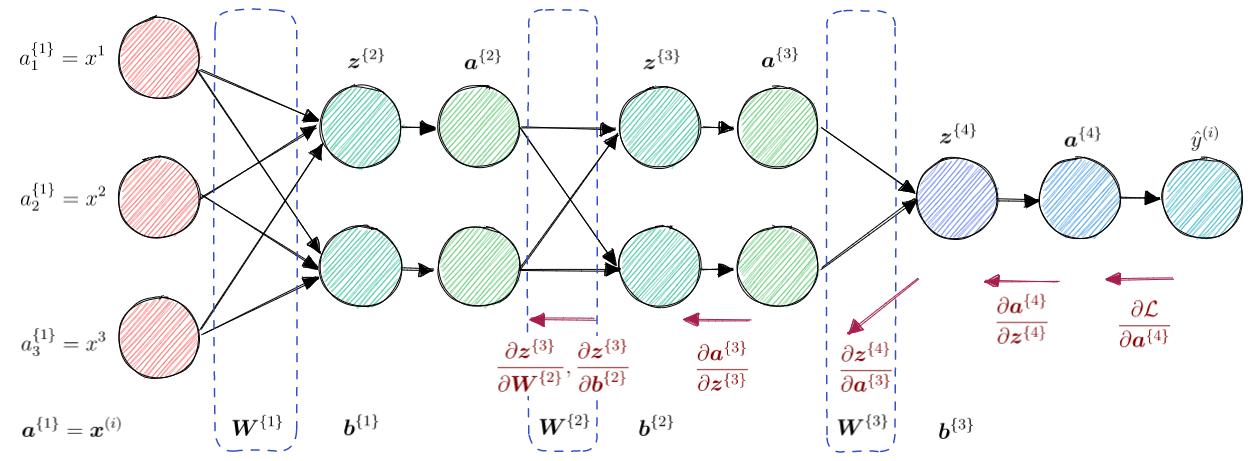

El cálculo de las derivadas parciales de la función de pérdida respecto a los parámetros de la última capa oculta es:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}  \frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}} &= \underbrace{\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}}_{\boldsymbol{\delta}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}}_{\boldsymbol{\delta}^{\left \{ 2 \right \}}}  \frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}}
\end{align}

Como se observa, los primeros dos componentes de ambas parciales se calcularon en las parciales de la capa anterior, es decir, $\boldsymbol{\delta}^{\left \{ 3 \right \}}$. A continuación se calculan las derivadas parciales restantes:

\begin{align}
\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 3 \right \}} \cdot \boldsymbol{a}^{\left \{ 3 \right \}} + \boldsymbol{b}^{\left \{ 3 \right \}}  \right ]}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} = \boldsymbol{W}^{\left \{ 3 \right \}} \\
\frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}} &= \frac{\partial \sigma(\boldsymbol{z}^{\left \{ 3 \right \}})}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}={\sigma}'(\boldsymbol{z}^{\left \{ 3 \right \}})
\end{align}

Una vez calculados $\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}$ y $\frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}$, se obtiene $\boldsymbol{\delta}^{\left \{ 2 \right \}}$:

\begin{equation}
\boldsymbol{\delta}^{\left \{ 2 \right \}} = \boldsymbol{\delta}^{\left \{ 3 \right \}} \frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}} = \boldsymbol{\delta}^{\left \{ 3 \right \}} \boldsymbol{W}^{\left \{ 3 \right \}} {\sigma}'(\boldsymbol{z}^{\left \{ 3 \right \}})
\end{equation}


Las derivadas correspondientes a $\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}}$ y $\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}}$ se calculan a continuación:

\begin{align}
\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 2 \right \}} \cdot \boldsymbol{a}^{\left \{ 2 \right \}} + \boldsymbol{b}^{\left \{ 2 \right \}}  \right ]}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} = \boldsymbol{a}^{\left \{ 2 \right \}} \\
\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 2 \right \}} \cdot \boldsymbol{a}^{\left \{ 2 \right \}} + \boldsymbol{b}^{\left \{ 2 \right \}}  \right ]}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}} = 1
\end{align}

Por lo tanto, la derivada parcial de la pérdida respecto a los parámetros de la última capa oculta se calculan como:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} &= \boldsymbol{\delta}^{\left \{ 2 \right \}}\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} = \boldsymbol{\delta}^{\left \{ 2 \right \}}\boldsymbol{a}^{\left \{ 2 \right \}} \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}} &= \boldsymbol{\delta}^{\left \{ 2 \right \}}\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}} = \boldsymbol{\delta}^{\left \{ 2 \right \}}
\end{align}

### Cálculo de $\left [\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}},\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}}  \right ]$

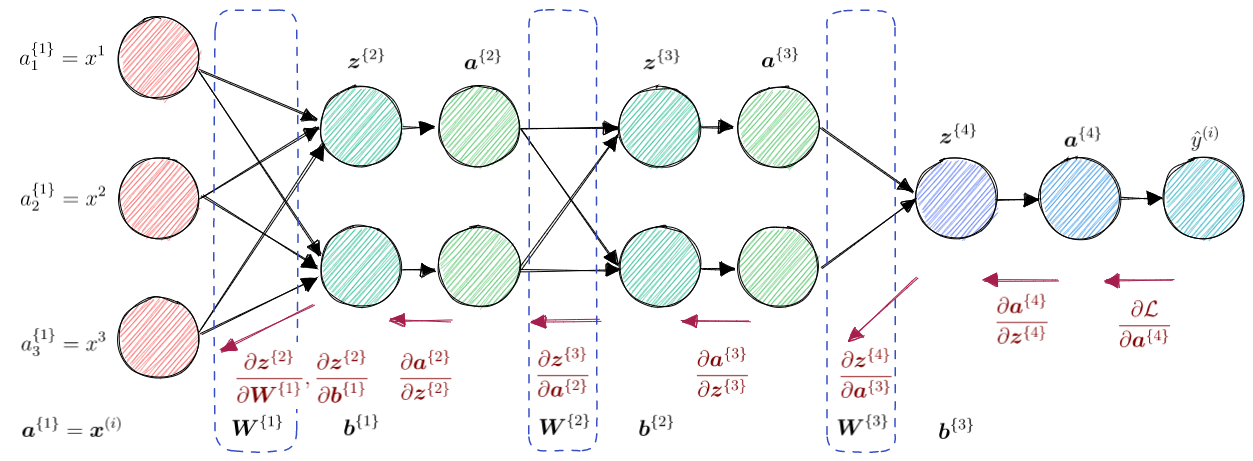

El cálculo de las derivadas parciales de la función de pérdida respecto a los parámetros de la primer capa oculta es:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}} &= \frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}  \frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{a}^{\left \{ 2 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 2 \right \}}}{\partial \boldsymbol{z}^{\left \{ 2 \right \}}} \frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}} \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}} &= \underbrace{\underbrace{\underbrace{\frac{\partial \mathcal{L}}{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}\frac{\partial \boldsymbol{a}^{\left \{ 4 \right \}}}{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}}_{\boldsymbol{\delta}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{z}^{\left \{ 4 \right \}}}{\partial \boldsymbol{a}^{\left \{ 3 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 3 \right \}}}{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}}_{\boldsymbol{\delta}^{\left \{ 2 \right \}}}  \frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{a}^{\left \{ 2 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 2 \right \}}}{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}}_{\boldsymbol{\delta}^{\left \{ 1 \right \}}} \frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}}
\end{align}

Como se observa, los primeros cuatro componentes de ambas parciales se calcularon en las parciales de la capa anterior, es decir, $\boldsymbol{\delta}^{\left \{ 2 \right \}}$. A continuación se calculan las derivadas parciales restantes:

\begin{align}
\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{a}^{\left \{ 2 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 2 \right \}} \cdot \boldsymbol{a}^{\left \{ 2 \right \}} + \boldsymbol{b}^{\left \{ 2 \right \}}  \right ]}{\partial \boldsymbol{a}^{\left \{ 2 \right \}}} = \boldsymbol{W}^{\left \{ 2 \right \}} \\
\frac{\partial \boldsymbol{a}^{\left \{ 2 \right \}}}{\partial \boldsymbol{z}^{\left \{ 2 \right \}}} &= \frac{\partial \sigma(\boldsymbol{z}^{\left \{ 2 \right \}})}{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}={\sigma}'(\boldsymbol{z}^{\left \{ 2 \right \}})
\end{align}

Una vez calculados $\frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{a}^{\left \{ 2 \right \}}}$ y $\frac{\partial \boldsymbol{a}^{\left \{ 2 \right \}}}{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}$, se obtiene $\boldsymbol{\delta}^{\left \{ 1 \right \}}$:

\begin{equation}
\boldsymbol{\delta}^{\left \{ 1 \right \}} = \boldsymbol{\delta}^{\left \{ 2 \right \}} \frac{\partial \boldsymbol{z}^{\left \{ 3 \right \}}}{\partial \boldsymbol{a}^{\left \{ 2 \right \}}} \frac{\partial \boldsymbol{a}^{\left \{ 2 \right \}}}{\partial \boldsymbol{z}^{\left \{ 2 \right \}}} = \boldsymbol{\delta}^{\left \{ 2 \right \}} \boldsymbol{W}^{\left \{ 2 \right \}} {\sigma}'(\boldsymbol{z}^{\left \{ 2 \right \}})
\end{equation}


Las derivadas correspondientes a $\frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}}$ y $\frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}}$ se calculan a continuación:

\begin{align}
\frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 1 \right \}} \cdot \boldsymbol{a}^{\left \{ 1 \right \}} + \boldsymbol{b}^{\left \{ 1 \right \}}  \right ]}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}} = \boldsymbol{a}^{\left \{ 1 \right \}} = \boldsymbol{x}^{(i)}\\
\frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}} &= \frac{\partial \left [\boldsymbol{W}^{\left \{ 1 \right \}} \cdot \boldsymbol{a}^{\left \{ 1 \right \}} + \boldsymbol{b}^{\left \{ 1 \right \}}  \right ]}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}} = 1
\end{align}

Por lo tanto, la derivada parcial de la pérdida respecto a los parámetros de la primera capa oculta se calculan como:

\begin{align}
\frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}} &= \boldsymbol{\delta}^{\left \{ 1 \right \}}\frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}} = \boldsymbol{\delta}^{\left \{ 1 \right \}}\boldsymbol{x}^{(i)} \\
\frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}} &= \boldsymbol{\delta}^{\left \{ 1 \right \}}\frac{\partial \boldsymbol{z}^{\left \{ 2 \right \}}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}} = \boldsymbol{\delta}^{\left \{ 1 \right \}}
\end{align}

## Actualización de los parámetros

Una vez calculados las derivadas parciales de la pérdida respecto a los pesos y sesgos ($\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}}$), los parámetros son actualizados tal que:

\begin{align}
\boldsymbol{W}_{[t+1]}^{\left \{ 3 \right \}} &= \boldsymbol{W}_{[t]}^{\left \{ 3 \right \}} - \alpha \frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 3 \right \}}}\\
\boldsymbol{b}_{[t+1]}^{\left \{ 3 \right \}} &= \boldsymbol{b}_{[t]}^{\left \{ 3 \right \}} - \alpha \frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 3 \right \}}}\\
\boldsymbol{W}_{[t+1]}^{\left \{ 2 \right \}} &= \boldsymbol{W}_{[t]}^{\left \{ 2 \right \}} - \alpha \frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 2 \right \}}}\\
\boldsymbol{b}_{[t+1]}^{\left \{ 2 \right \}} &= \boldsymbol{b}_{[t]}^{\left \{ 2 \right \}} - \alpha \frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 2 \right \}}}\\
\boldsymbol{W}_{[t+1]}^{\left \{ 1 \right \}} &= \boldsymbol{W}_{[t]}^{\left \{ 1 \right \}} - \alpha \frac{\partial \mathcal{L}}{\partial \boldsymbol{W}^{\left \{ 1 \right \}}}\\
\boldsymbol{b}_{[t+1]}^{\left \{ 1 \right \}} &= \boldsymbol{b}_{[t]}^{\left \{ 1 \right \}} - \alpha \frac{\partial \mathcal{L}}{\partial \boldsymbol{b}^{\left \{ 1 \right \}}}
\end{align}

El algoritmo consta de:
1. Asignar valores aleatorios a los parámetros $\boldsymbol{\theta}$. Los pesos $\boldsymbol{W}$ normalmente se inicializan con valores pequeños con una distribución normal y uniforme, además existen diferentes inicializadores. $\boldsymbol{W}\neq 0$ para romper la simetría. Los sesgos pueden ser $\boldsymbol{b}=0$ porque son independientes.
2. Ejecutar para un número de épocas definida:
  1. Propagación de la entrada $\boldsymbol{x}^{(i)}$ hacia delante para generar la predicción $\boldsymbol{\hat{y}}^{(i)}$
  2. Calcular las derivadas parciales de la pérdida respecto a cada paso y sesgo capa por capa, comenzando con la salida y propagándose hacia atrás para calcular las de la capa anterior.
  3. Actualizar los parámetros con $\boldsymbol{\theta}^{\left [ t+1 \right ]} = \boldsymbol{\theta}^{\left [ t \right ]}-\alpha \nabla \mathcal{L}(\boldsymbol{\theta}^{\left [ t \right ]})$

In [8]:
def backpropagation(X,y,n_epocas,alpha,n_ocultas_h1,n_ocultas_h2):
  n_ejemplos = X.shape[0]
  n_entradas = X.shape[1]

  # inicializacion de las matrices de pesos (W) y sesgos
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas_h1)
  b1 = np.zeros((n_ocultas_h1, 1))

  W2 = np.sqrt(1.0 / n_ocultas_h1) * np.random.randn(n_ocultas_h1, n_ocultas_h2)
  b2 = np.zeros((n_ocultas_h2, 1))

  W3 = np.sqrt(1.0 / n_ocultas_h2) * np.random.randn(n_ocultas_h2, 1)
  b3 = np.zeros((1, 1))

  # inicializacion de vector de perdidas (de tamaño del numero de epocas)
  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_hat_e = np.zeros((y.shape))

  # realizar un paso forward, backprop y actualizacion por epoca
  for i in range(n_epocas):
    # iterar sobre cada ejemplo
    for j in range(n_ejemplos):
      # forward
      z2,a2,z3,a3,z4,y_hat = forward(X[j],W1,b1,W2,b2,W3,b3)

      # calculo de gradientes por capa
      ## capa de salida
      delta3 = y_hat - y[j]
      dW3 = np.outer(a3,delta3)
      db3 = delta3

      ## segunda capa oculta
      delta2 = np.dot(W3,delta3) * derivada_sigmoide(z3)
      dW2 = np.outer(a2,delta2)
      db2 = delta2

      ## primera capa oculta
      delta1 = np.dot(W2,delta2) * derivada_sigmoide(z2)
      dW1 = np.outer(X[j],delta1)
      db1 = delta1

      # actualizacion de los parametros
      W3 -= alpha * dW3
      b3 -= alpha * db3
      W2 -= alpha * dW2
      b2 -= alpha * db2
      W1 -= alpha * dW1
      b1 -= alpha * db1

      y_hat_e[j] = y_hat

    # calculo de las perdidas y exactitudes
    perdidas[i] = entropia_cruzada_binaria(y, y_hat_e)
    exactitudes[i] = exactitud(y, np.round(y_hat_e))
    print(f'Epoch {i}: Pérdida = {perdidas[i]:.3f} Exactitud = {exactitudes[i]:.3f}')

  return W1,W2,W3,perdidas,exactitudes,y_hat_e


## Ejemplo

### Generación de datos

Los datos consisten en 2 grupos de datos (150 datos por grupo) con un centro y una distribución aleatoria entre ellos, por lo tanto, se vuelve en un problema de clasificación binaria. Las etiquetas tienen valores de 0 para el primer grupo y de 1 para el segundo.

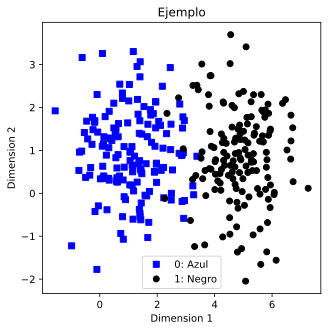

In [9]:
# crear datos
datos_por_cluster = 150
blur = 1

# centro de los datos
A = [  1, 1 ]
B = [  5, 1 ]

# generar data
a = [ A[0]+np.random.randn(datos_por_cluster)*blur , 
     A[1]+np.random.randn(datos_por_cluster)*blur ]
b = [ B[0]+np.random.randn(datos_por_cluster)*blur , 
     B[1]+np.random.randn(datos_por_cluster)*blur ]

# etiquetas
labels_np = np.vstack((np.zeros((datos_por_cluster,1)),
                       np.ones((datos_por_cluster,1))))

# concatenar en una matriz
data_np = np.hstack((a,b)).T

# mostrar los datos
fig = plt.figure(figsize=(5,5))
plt.plot(data_np[np.where(labels_np==0)[0],0],data_np[np.where(labels_np==0)[0],1],
         'bs',label='0: Azul')
plt.plot(data_np[np.where(labels_np==1)[0],0],data_np[np.where(labels_np==1)[0],1],
         'ko',label='1: Negro')
plt.title('Ejemplo')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

El conjunto de datos cuenta con 300 ejemplos, que son 150 ejemplos por categoría. Y cada ejemplo cuenta con 2 entradas, que son la posición $x,y$ respectivamente.

In [10]:
# informacion general
print(f'Dimensiones de X: {data_np.shape}')
print(f'Dimensiones de y: {labels_np.shape}')

Dimensiones de X: (300, 2)
Dimensiones de y: (300, 1)


### Ejecución del ejemplo

In [11]:
W1, W2, W3, perdidas, exactitudes, y_hat_e = backpropagation(data_np,labels_np,
                                                n_epocas=100,
                                                alpha=0.01,
                                                n_ocultas_h1=5,
                                                n_ocultas_h2=5)

Epoch 0: Pérdida = 189.365 Exactitud = 66.333
Epoch 1: Pérdida = 198.112 Exactitud = 61.000
Epoch 2: Pérdida = 199.694 Exactitud = 60.333
Epoch 3: Pérdida = 199.616 Exactitud = 60.333
Epoch 4: Pérdida = 199.225 Exactitud = 60.667
Epoch 5: Pérdida = 198.758 Exactitud = 60.667
Epoch 6: Pérdida = 198.234 Exactitud = 61.000
Epoch 7: Pérdida = 197.631 Exactitud = 61.000
Epoch 8: Pérdida = 196.905 Exactitud = 61.333
Epoch 9: Pérdida = 196.004 Exactitud = 62.333
Epoch 10: Pérdida = 194.863 Exactitud = 62.333
Epoch 11: Pérdida = 193.421 Exactitud = 63.000
Epoch 12: Pérdida = 191.626 Exactitud = 63.667
Epoch 13: Pérdida = 189.432 Exactitud = 64.667
Epoch 14: Pérdida = 186.781 Exactitud = 67.667
Epoch 15: Pérdida = 183.597 Exactitud = 69.333
Epoch 16: Pérdida = 179.781 Exactitud = 70.667
Epoch 17: Pérdida = 175.218 Exactitud = 73.000
Epoch 18: Pérdida = 169.792 Exactitud = 75.667
Epoch 19: Pérdida = 163.408 Exactitud = 78.000
Epoch 20: Pérdida = 156.029 Exactitud = 78.667
Epoch 21: Pérdida = 147

### Visualización de resultados

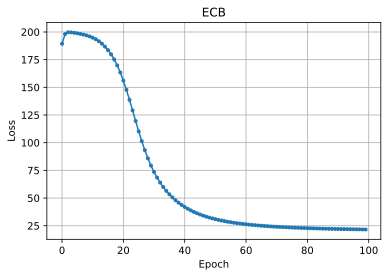

In [12]:
# grafica de perdidas
plt.plot(perdidas,marker='.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ECB')
plt.grid(True)
plt.show()

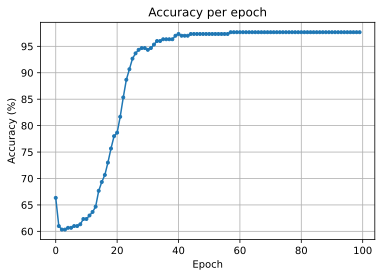

In [13]:
# grafica de exactitud
plt.plot(exactitudes,marker='.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per epoch')
plt.grid(True)
plt.show()

A continuación se buscan los datos que estuvieron mal etiquetados en el modelo, para ello se considera que los datos que tengan una $\hat{y}>0.5$ pertecen a la categoría 1, y en caso contrario, pertenecen a la categoría 0.

In [14]:
pred_labels = y_hat_e > 0.5
# encontrar errores
errores = np.where(pred_labels != labels_np)[0]
# accuracy total
accuracy = (1 - len(errores)/(2*datos_por_cluster))*100

print(f'Accuracy: {accuracy:.1f}%')

Accuracy: 97.7%


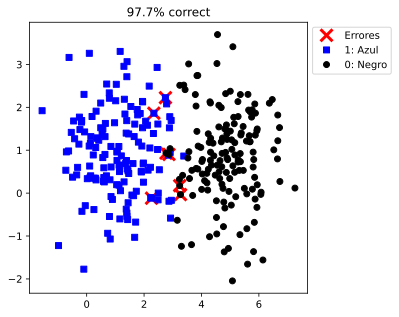

In [15]:
# grafica de los errores
fig = plt.figure(figsize=(5,5))
plt.plot(data_np[errores,0] ,data_np[errores,1],'rx',
         markersize=12,markeredgewidth=3)
plt.plot(data_np[np.where(~pred_labels)[0],0],
         data_np[np.where(~pred_labels)[0],1],'bs')
plt.plot(data_np[np.where(pred_labels)[0],0] ,
         data_np[np.where(pred_labels)[0],1] ,'ko')

plt.legend(['Errores','1: Azul','0: Negro'],bbox_to_anchor=(1,1))
plt.title(f'{accuracy:.1f}% correct')
plt.show()